In [ ]:
!pip install pyspark

In [ ]:
import os
import sys

os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

In [ ]:
import re
import datetime
from pyspark.sql import Row
from pyspark.sql import SparkSession

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
APACHE_ACCESS_LOG_PATTERN = r'^(\S+) (\S+) (\S+) \[([\w:/]+\s[+\-]\d{4})\] "(\S+) (\S+)\s*(\S*)\s*" (\d{3}) (\S+)'

month_map = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6, 'Jul': 7,
             'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}

In [ ]:
def parse_apache_time(s):
    return datetime.datetime(int(s[7:11]),
                             month_map[s[3:6]],
                             int(s[0:2]),
                             int(s[12:14]),
                             int(s[15:17]),
                             int(s[18:20]))

def parseApacheLogLine(logline):
    match = re.search(APACHE_ACCESS_LOG_PATTERN, logline)
    if match is None:
        return (logline, 0)
    size_field = match.group(9)
    if size_field == '-':
        size = int(0)
    else:
        size = int(match.group(9))
    return (Row(
        host=match.group(1),
        client_identd=match.group(2),
        user_id=match.group(3),
        date_time=parse_apache_time(match.group(4)),
        method=match.group(5),
        endpoint=match.group(6),
        protocol=match.group(7),
        response_code=int(match.group(8)),
        content_size=size
    ), 1)


In [ ]:
spark = SparkSession.builder.appName("LogParser").getOrCreate()

In [ ]:
log_file = "/content/drive/MyDrive/access_log_Aug95"  # Replace with the path to your log file
log_data = spark.sparkContext.textFile(log_file)

In [ ]:
parsed_data = log_data.map(parseApacheLogLine).filter(lambda x: x[1] == 1).map(lambda x: x[0])


In [ ]:
log_df = spark.createDataFrame(parsed_data)


In [ ]:
output_csv = "parsed_log_data.csv"  # Use the existing file name
log_df.coalesce(1).write.mode("overwrite").option("header", "true").csv(output_csv)


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [ ]:
csv_file = "/content/parsed_log_data.csv/part-00000-d371c7a1-1175-4da3-bb39-67c270b582d5-c000.csv"
data = pd.read_csv(csv_file, error_bad_lines=False)


<ipython-input-50-c497ef190d53>:2: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(csv_file, error_bad_lines=False)
Skipping line 275355: expected 9 fields, saw 10

Skipping line 428663: expected 9 fields, saw 10

Skipping line 1265428: expected 9 fields, saw 10



In [ ]:
print(data.head())

                host client_identd user_id                 date_time method  \
0  in24.inetnebr.com             -       -  1995-08-01T00:00:01.000Z    GET   
1    uplherc.upl.com             -       -  1995-08-01T00:00:07.000Z    GET   
2    uplherc.upl.com             -       -  1995-08-01T00:00:08.000Z    GET   
3    uplherc.upl.com             -       -  1995-08-01T00:00:08.000Z    GET   
4    uplherc.upl.com             -       -  1995-08-01T00:00:08.000Z    GET   

                                          endpoint  protocol  response_code  \
0  /shuttle/missions/sts-68/news/sts-68-mcc-05.txt  HTTP/1.0            200   
1                                                /  HTTP/1.0            304   
2                       /images/ksclogo-medium.gif  HTTP/1.0            304   
3                     /images/MOSAIC-logosmall.gif  HTTP/1.0            304   
4                        /images/USA-logosmall.gif  HTTP/1.0            304   

   content_size  
0          1839  
1             

In [ ]:
data.columns

Index(['host', 'client_identd', 'user_id', 'date_time', 'method', 'endpoint',
       'protocol', 'response_code', 'content_size'],
      dtype='object')

In [ ]:
print(data)

                           host client_identd user_id  \
0             in24.inetnebr.com             -       -   
1               uplherc.upl.com             -       -   
2               uplherc.upl.com             -       -   
3               uplherc.upl.com             -       -   
4               uplherc.upl.com             -       -   
...                         ...           ...     ...   
1568738     gatekeeper.uccu.com             -       -   
1568739     gatekeeper.uccu.com             -       -   
1568740   cys-cap-9.wyoming.com             -       -   
1568741    www-c8.proxy.aol.com             -       -   
1568742  cindy.yamato.ibm.co.jp             -       -   

                        date_time method  \
0        1995-08-01T00:00:01.000Z    GET   
1        1995-08-01T00:00:07.000Z    GET   
2        1995-08-01T00:00:08.000Z    GET   
3        1995-08-01T00:00:08.000Z    GET   
4        1995-08-01T00:00:08.000Z    GET   
...                           ...    ...   
1568738

In [ ]:

print(data.columns)

Index(['host', 'client_identd', 'user_id', 'date_time', 'method', 'endpoint',
       'protocol', 'response_code', 'content_size'],
      dtype='object')


In [ ]:
categorical_columns = ['host', 'client_identd', 'user_id', 'method', 'endpoint', 'protocol','date_time']


In [ ]:
sample_data = data.sample(frac=0.5, random_state=42)

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Initialize the label encoder
label_encoder = LabelEncoder()



In [ ]:
# Encode the categorical columns
for column in categorical_columns:
    sample_data[column] = label_encoder.fit_transform(sample_data[column])

In [ ]:
sample_data = sample_data.drop('date_time', axis=1)

In [ ]:
X = sample_data.drop("response_code", axis=1)  # Features
y = sample_data["response_code"]  # Labels

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
model = RandomForestClassifier()
model.fit(X_train, y_train)

RandomForestClassifier()

In [ ]:

y_pred = model.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.9968318725099602


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score


filepath = "/content/parsed_log_data.csv/part-00000-d371c7a1-1175-4da3-bb39-67c270b582d5-c000.csv"
df1 = spark.read.csv(filepath, header=True)




In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.sql import SparkSession
from pyspark.sql.functions import when
from pyspark.sql.types import IntegerType
import pyspark.sql.functions as F

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import when
from pyspark.sql.types import IntegerType

# Initialize a Spark session
spark = SparkSession.builder.appName("LeatherDefectClassification").getOrCreate()

df1 = df1.withColumn("response_code", when(df1["response_code"] > 0, 1).otherwise(0).cast(IntegerType()))

inputColumns = ['client_identd', 'user_id', 'content_size']
outputColumn = "features"


for col_name in inputColumns:
    df1 = df1.withColumn(col_name, df1[col_name].cast(IntegerType()))

# Fill null values in the DataFrame
df1 = df1.fillna(0, subset=inputColumns)

price_indexer = StringIndexer(inputCol="response_code", outputCol="responseIndex")

vector_assembler = VectorAssembler(inputCols=inputColumns, outputCol=outputColumn, handleInvalid="skip")
dt_model = DecisionTreeClassifier(labelCol="response_code", featuresCol=outputColumn)

stages = [price_indexer, vector_assembler, dt_model]

pipeline = Pipeline(stages=stages)

(train_df2, test_df2) = df1.randomSplit([0.8, 0.2], seed=11)

final_pipeline = pipeline.fit(train_df2)
test_predictions_from_pipeline = final_pipeline.transform(test_df2)

test_predictions_from_pipeline.select("response_code", "prediction").show(5)

evaluator = MulticlassClassificationEvaluator(labelCol="response_code", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(test_predictions_from_pipeline)
print(f"Accuracy: {accuracy}")



+-------------+----------+
|response_code|prediction|
+-------------+----------+
|            1|       1.0|
|            1|       1.0|
|            1|       1.0|
|            1|       1.0|
|            1|       1.0|
+-------------+----------+
only showing top 5 rows

Accuracy: 1.0


In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

param_grid = ParamGridBuilder() \
    .addGrid(dt_model.maxDepth, [5, 10, 15]) \
    .addGrid(dt_model.maxBins, [32, 64, 128]) \
    .build()


cv = CrossValidator(estimator=pipeline,
                    estimatorParamMaps=param_grid,
                    evaluator=evaluator,
                    numFolds=5)
cv_model = cv.fit(train_df2)


test_predictions_from_cv = cv_model.transform(test_df2)

test_predictions_from_cv.select("response_code", "prediction").show(5)

# Evaluate the model's performance
accuracy = evaluator.evaluate(test_predictions_from_cv)
print(f"Accuracy: {accuracy}")


+-------------+----------+
|response_code|prediction|
+-------------+----------+
|            1|       1.0|
|            1|       1.0|
|            1|       1.0|
|            1|       1.0|
|            1|       1.0|
+-------------+----------+
only showing top 5 rows

Accuracy: 1.0


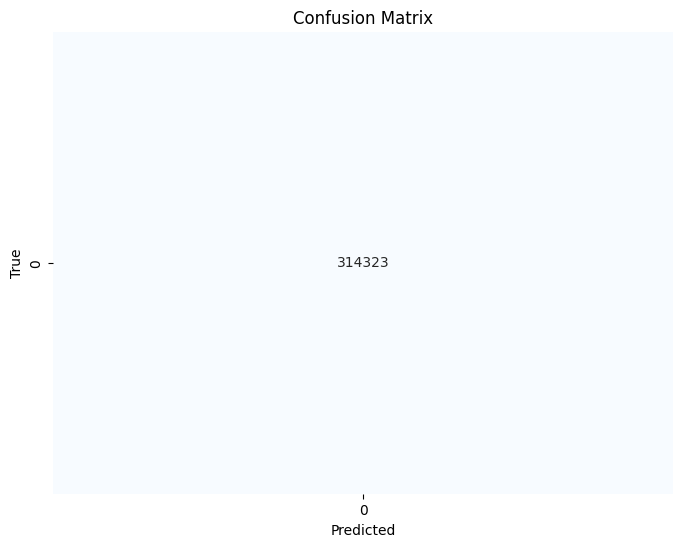

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

true_labels = test_predictions_from_cv.select("response_code").rdd.flatMap(lambda x: x).collect()
predicted_labels = test_predictions_from_cv.select("prediction").rdd.flatMap(lambda x: x).collect()


cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
!pip install matplotlib seaborn


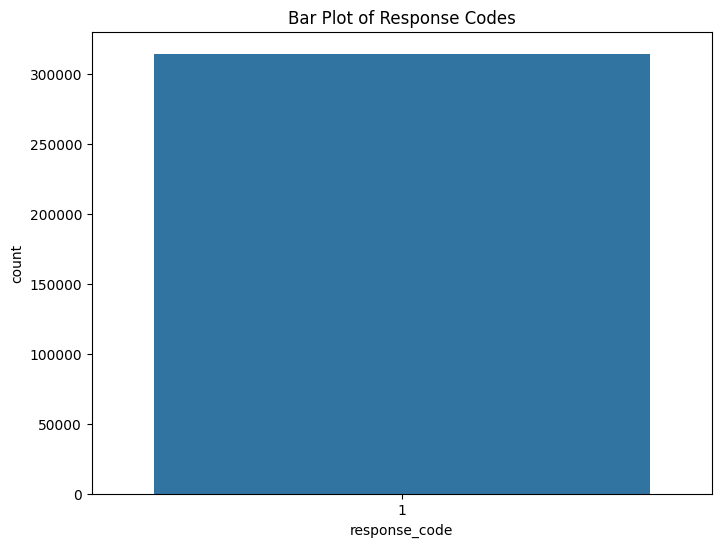

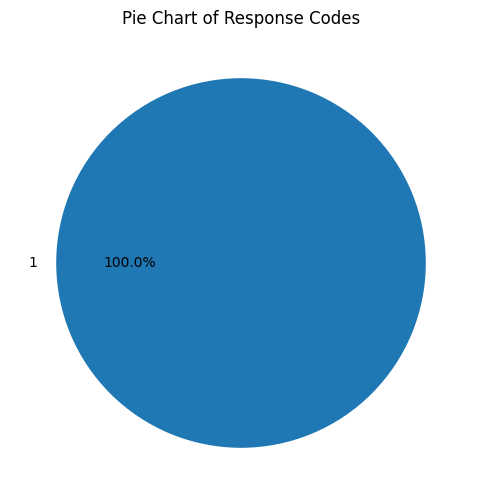

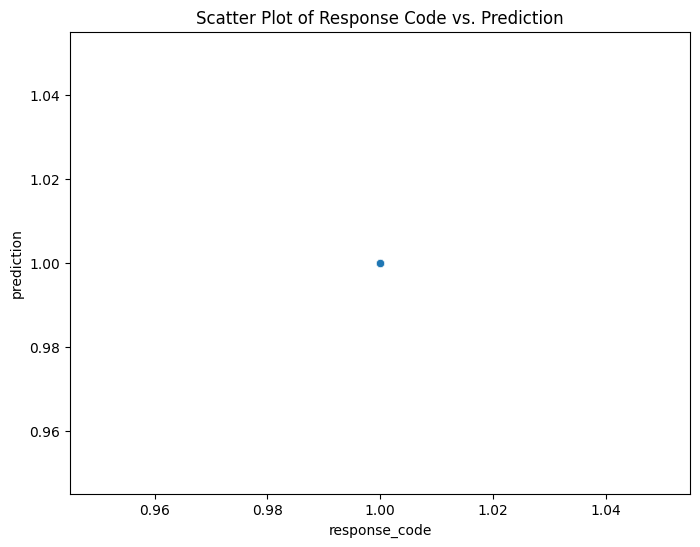

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


data = test_predictions_from_pipeline.select("response_code", "prediction").toPandas()

# Bar Plot
plt.figure(figsize=(8, 6))
sns.countplot(data=data, x="response_code")
plt.title("Bar Plot of Response Codes")
plt.show()

# Pie Chart
plt.figure(figsize=(8, 6))
plt.pie(data["response_code"].value_counts(), labels=data["response_code"].unique(), autopct='%1.1f%%')
plt.title("Pie Chart of Response Codes")
plt.show()

# Scatter Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=data, x="response_code", y="prediction")
plt.title("Scatter Plot of Response Code vs. Prediction")
plt.show()


In [ ]:
import pandas as pd

# Create a sample test DataFrame
data = {
    'client_identd': [1, 2, 3, 4, 5],
    'user_id': [101, 102, 103, 104, 105],
    'content_size': [1000, 1500, 800, 1200, 1600],
}

data['response_code'] = [0, 1, 0, 1, 0]

test_df = pd.DataFrame(data)